In [2]:
# Essential imports for data science and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configure visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Environment Setup:")
print(f"   Device: {device}")
print(f"   PyTorch Version: {torch.__version__}")
print(f"   Pandas Version: {pd.__version__}")
print(f"   NumPy Version: {np.__version__}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("\n✅ All libraries imported successfully!")
print("📊 Ready to begin customer churn analysis...")

🚀 Environment Setup:
   Device: cpu
   PyTorch Version: 2.8.0+cpu
   Pandas Version: 2.3.3
   NumPy Version: 2.3.3

✅ All libraries imported successfully!
📊 Ready to begin customer churn analysis...


In [3]:
# Redefining Model Architecture to perform comprehensive analysis

class ChurnPredictor(nn.Module):
    """
    Deep Neural Network for Customer Churn Prediction

    Architecture:
    - Input: All engineered features
    - Hidden layers with batch normalization and dropout
    - Output: Binary classification (churn probability)
    """

    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.2):
        super(ChurnPredictor, self).__init__()

        # Build dynamic architecture
        layers = []
        prev_size = input_size

        for i, hidden_size in enumerate(hidden_sizes):
            # Linear layer
            layers.append(nn.Linear(prev_size, hidden_size))
            # Batch normalization
            layers.append(nn.BatchNorm1d(hidden_size))
            # Activation
            layers.append(nn.ReLU())
            # Dropout
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, 1))
        # layers.append(nn.Sigmoid())  # Sigmoid will be applied in the loss function (BCEWithLogitsLoss)

        self.network = nn.Sequential(*layers)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Xavier/Glorot initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.network(x)

In [5]:
import pickle
import torch

# 1. Load preprocessing pipeline
with open('../outputs/preprocessing_pipeline.pkl', 'rb') as f:
    pipeline_objects = pickle.load(f)
    
# Extract all preprocessing objects
scaler = pipeline_objects['scaler']
label_encoders = pipeline_objects['label_encoders']
feature_columns = pipeline_objects['feature_columns']
categorical_features = pipeline_objects['categorical_features']
numerical_features = pipeline_objects['numerical_features']
binary_features = pipeline_objects['binary_features']
class_weight_dict = pipeline_objects['class_weight_dict']

# Save preprocessing objects for later use
preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'class_weights': class_weight_dict
}

# 2. Load PyTorch tensors
with open('../outputs/tensors/tensor_data.pkl', 'rb') as f:
    tensor_objects = pickle.load(f)
    
# Extract all tensors
X_train_tensor = tensor_objects['X_train_tensor']
X_test_tensor = tensor_objects['X_test_tensor']
y_train_tensor = tensor_objects['y_train_tensor']
y_test_tensor = tensor_objects['y_test_tensor']

# 3. Load trained model weights (if needed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Get input size from our feature matrix
input_size = X_train_tensor.shape[1]
print(f"   ✅ Input size: {input_size} features")

# Create model instance
model = ChurnPredictor(
    input_size=input_size,
    hidden_sizes=[256, 128, 64],  # Progressive reduction
    dropout_rate=0.2
).to(device)

print(f"   ✅ Model created and moved to {device}")
print(f"   ✅ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Model summary
print(f"\n📋 MODEL ARCHITECTURE:")
print(model)

   ✅ Input size: 41 features
   ✅ Model created and moved to cpu
   ✅ Total parameters: 52,865

📋 MODEL ARCHITECTURE:
ChurnPredictor(
  (network): Sequential(
    (0): Linear(in_features=41, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [7]:
model.load_state_dict(torch.load('../outputs/best_churn_model.pth'))

<All keys matched successfully>

In [11]:
y_test = pd.read_csv("../data/preprocessed/y_test.csv")
y_val_split = pd.read_csv("../data/val-split/y_val_split.csv")

with open('../outputs/tensors/train_validation_split_tensors.pkl', 'rb') as f:
    tensor_objects = pickle.load(f)
    
# Extract all tensors
X_train_split_tensor = tensor_objects['X_train_split_tensor']
X_val_split_tensor = tensor_objects['X_val_split_tensor']
y_train_split_tensor = tensor_objects['y_train_split_tensor']
y_val_split_tensor = tensor_objects['y_val_split_tensor']


In [12]:
# Comprehensive Model Evaluation and Business Analysis
print("📊 COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                           precision_recall_curve, roc_auc_score, average_precision_score)

# 1. FINAL MODEL PREDICTIONS
print("1️⃣ Generating Final Predictions...")

model.eval()
with torch.no_grad():
    # Test set predictions
    test_outputs = model(X_test_tensor).squeeze()
    test_probabilities = torch.sigmoid(test_outputs).cpu().numpy()
    test_predictions = (test_probabilities > 0.5).astype(int)

    # Validation set predictions (for comparison)
    val_outputs = model(X_val_split_tensor).squeeze()
    val_probabilities = torch.sigmoid(val_outputs).cpu().numpy()
    val_predictions = (val_probabilities > 0.5).astype(int)

y_test_np = y_test.values
y_val_np = y_val_split

print(f"   ✅ Test predictions generated: {len(test_predictions)} samples")
print(f"   ✅ Validation predictions: {len(val_predictions)} samples")

📊 COMPREHENSIVE MODEL EVALUATION
1️⃣ Generating Final Predictions...
   ✅ Test predictions generated: 1409 samples
   ✅ Validation predictions: 1126 samples



2️⃣ Confusion Matrix Analysis...


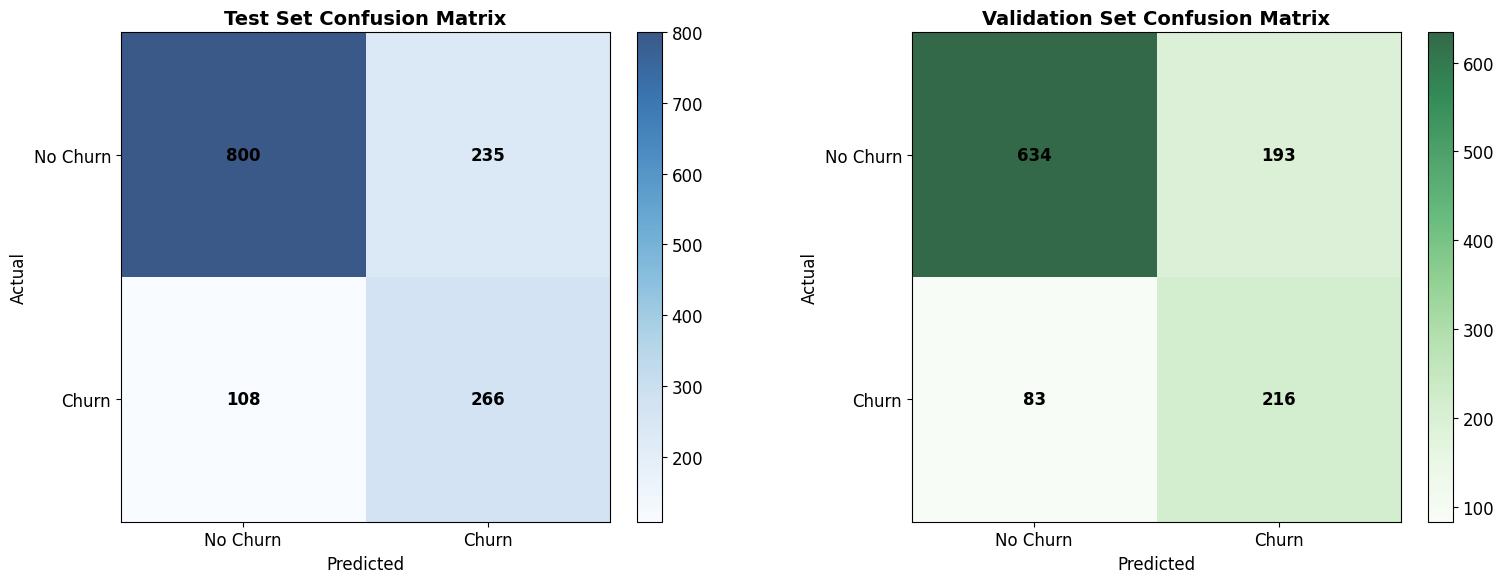

In [13]:
# 2. CONFUSION MATRIX ANALYSIS
print(f"\n2️⃣ Confusion Matrix Analysis...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Test set confusion matrix
cm_test = confusion_matrix(y_test_np, test_predictions)
im1 = ax1.imshow(cm_test, cmap='Blues', alpha=0.8)
ax1.set_title('Test Set Confusion Matrix', fontweight='bold', fontsize=14)

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax1.text(j, i, cm_test[i, j], ha="center", va="center",
                       color="black", fontsize=12, fontweight='bold')

ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['No Churn', 'Churn'])
ax1.set_yticklabels(['No Churn', 'Churn'])

# Add colorbar
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Validation set confusion matrix
cm_val = confusion_matrix(y_val_np, val_predictions)
im2 = ax2.imshow(cm_val, cmap='Greens', alpha=0.8)
ax2.set_title('Validation Set Confusion Matrix', fontweight='bold', fontsize=14)

for i in range(2):
    for j in range(2):
        text = ax2.text(j, i, cm_val[i, j], ha="center", va="center",
                       color="black", fontsize=12, fontweight='bold')

ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['No Churn', 'Churn'])
ax2.set_yticklabels(['No Churn', 'Churn'])
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


3️⃣ ROC Curve Analysis...


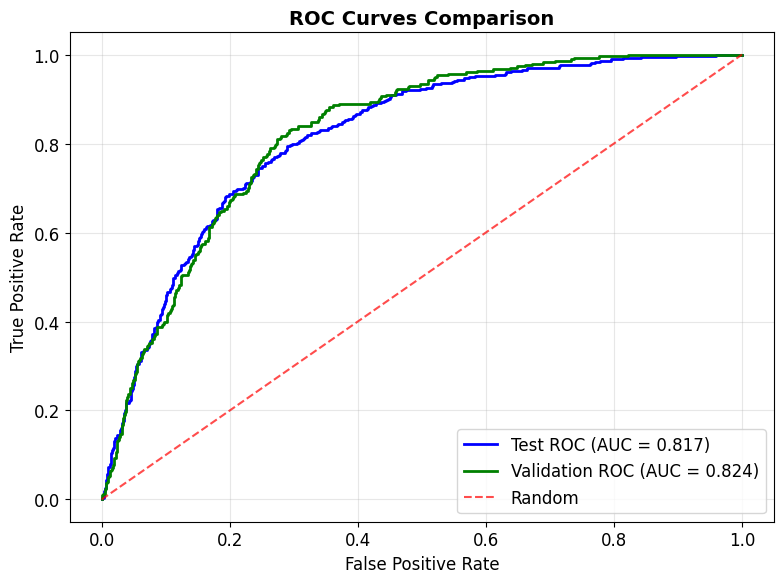

In [14]:
# 3. ROC CURVE
print(f"3️⃣ ROC Curve Analysis...")

# Calculate ROC curves
fpr_test, tpr_test, _ = roc_curve(y_test_np, test_probabilities)
fpr_val, tpr_val, _ = roc_curve(y_val_np, val_probabilities)

roc_auc_test = roc_auc_score(y_test_np, test_probabilities)
roc_auc_val = roc_auc_score(y_val_np, val_probabilities)

# Create single ROC plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(fpr_test, tpr_test, color='blue', linewidth=2,
        label=f'Test ROC (AUC = {roc_auc_test:.3f})')
ax.plot(fpr_val, tpr_val, color='green', linewidth=2,
        label=f'Validation ROC (AUC = {roc_auc_val:.3f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--', alpha=0.7, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


4️⃣ Precision-Recall Analysis...


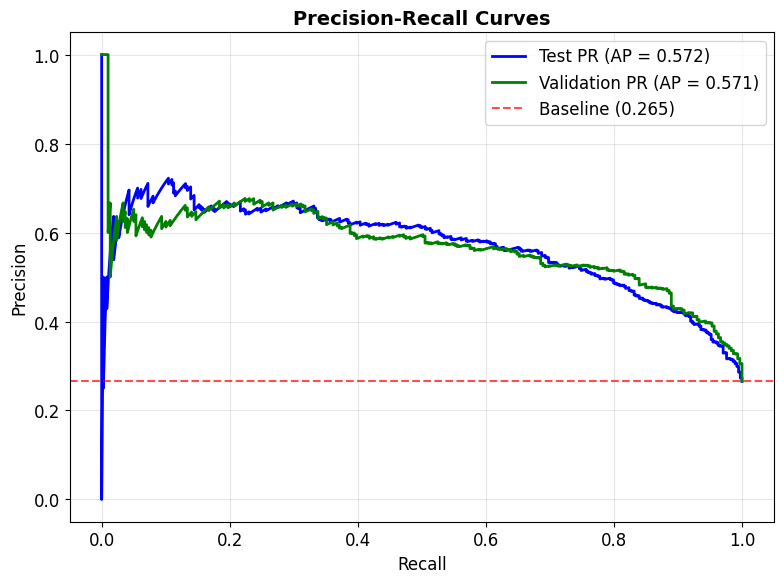

In [15]:
# 4. PRECISION-RECALL CURVE
print(f"4️⃣ Precision-Recall Analysis...")

precision_test, recall_test, _ = precision_recall_curve(y_test_np, test_probabilities)
precision_val, recall_val, _ = precision_recall_curve(y_val_np, val_probabilities)

avg_precision_test = average_precision_score(y_test_np, test_probabilities)
avg_precision_val = average_precision_score(y_val_np, val_probabilities)

# Create single PR plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(recall_test, precision_test, color='blue', linewidth=2,
        label=f'Test PR (AP = {avg_precision_test:.3f})')
ax.plot(recall_val, precision_val, color='green', linewidth=2,
        label=f'Validation PR (AP = {avg_precision_val:.3f})')

# Baseline (random classifier for imbalanced data)
baseline = y_test_np.mean()
ax.axhline(y=baseline, color='red', linestyle='--', alpha=0.7,
           label=f'Baseline ({baseline:.3f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# 5. DETAILED CLASSIFICATION REPORTS
print(f"\n5️⃣ Detailed Classification Reports...")

print(f"\n🎯 TEST SET PERFORMANCE:")
print("=" * 40)
test_report = classification_report(y_test_np, test_predictions,
                                  target_names=['No Churn', 'Churn'],
                                  output_dict=True)
print(classification_report(y_test_np, test_predictions,
                          target_names=['No Churn', 'Churn']))

print(f"\n🎯 VALIDATION SET PERFORMANCE:")
print("=" * 40)
val_report = classification_report(y_val_np, val_predictions,
                                 target_names=['No Churn', 'Churn'],
                                 output_dict=True)
print(classification_report(y_val_np, val_predictions,
                          target_names=['No Churn', 'Churn']))


5️⃣ Detailed Classification Reports...

🎯 TEST SET PERFORMANCE:
              precision    recall  f1-score   support

    No Churn       0.88      0.77      0.82      1035
       Churn       0.53      0.71      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409


🎯 VALIDATION SET PERFORMANCE:
              precision    recall  f1-score   support

    No Churn       0.88      0.77      0.82       827
       Churn       0.53      0.72      0.61       299

    accuracy                           0.75      1126
   macro avg       0.71      0.74      0.72      1126
weighted avg       0.79      0.75      0.77      1126



In [19]:
# 6. BUSINESS IMPACT ANALYSIS
print(f"\n6️⃣ Business Impact Analysis...")

df_features = pd.read_csv('../data/preprocessed/clean-processed-data.csv')
# Extract key metrics
test_precision = test_report['Churn']['precision']
test_recall = test_report['Churn']['recall']
test_f1 = test_report['Churn']['f1-score']

# Business assumptions (you would get these from business stakeholders)
avg_customer_monthly_revenue = df_features['MonthlyCharges'].mean()
avg_customer_lifetime_months = df_features['tenure'].mean()
retention_campaign_cost = 50  # Cost per targeted customer
retention_success_rate = 0.3  # 30% of targeted customers are retained

print(f"💰 BUSINESS IMPACT CALCULATION:")
print("=" * 45)

# Calculate financial metrics - Convert numpy arrays to integers
total_test_customers = len(y_test_np)
actual_churners = int(sum(y_test_np))  # Convert to int
predicted_churners = int(sum(test_predictions))  # Convert to int

# True positives (correctly identified churners)
true_positives = int(cm_test[1, 1])  # Convert to int
false_positives = int(cm_test[0, 1])  # Convert to int
false_negatives = int(cm_test[1, 0])  # Convert to int

print(f"📊 Test Set Metrics:")
print(f"   • Total customers: {total_test_customers:,}")
print(f"   • Actual churners: {actual_churners:,}")
print(f"   • Predicted churners: {predicted_churners:,}")
print(f"   • True positives: {true_positives:,}")
print(f"   • False positives: {false_positives:,}")
print(f"   • False negatives: {false_negatives:,}")

# Financial impact calculations
customer_lifetime_value = avg_customer_monthly_revenue * avg_customer_lifetime_months

# Cost of retention campaign
campaign_cost = predicted_churners * retention_campaign_cost

# Revenue saved (true positives that are retained)
revenue_saved = true_positives * retention_success_rate * customer_lifetime_value

# Wasted campaign cost (false positives)
wasted_cost = false_positives * retention_campaign_cost

# Revenue lost (false negatives - churners we missed)
revenue_lost = false_negatives * customer_lifetime_value

# Net benefit
net_benefit = revenue_saved - campaign_cost

print(f"\n💵 Financial Impact:")
print(f"   • Customer Lifetime Value: ${customer_lifetime_value:,.0f}")
print(f"   • Campaign cost: ${campaign_cost:,.0f}")
print(f"   • Revenue saved: ${revenue_saved:,.0f}")
print(f"   • Wasted cost (false positives): ${wasted_cost:,.0f}")
print(f"   • Revenue lost (missed churners): ${revenue_lost:,.0f}")
print(f"   • Net benefit: ${net_benefit:,.0f}")

# ROI calculation
roi = (net_benefit / campaign_cost) * 100 if campaign_cost > 0 else 0
print(f"   • ROI: {roi:.1f}%")



6️⃣ Business Impact Analysis...
💰 BUSINESS IMPACT CALCULATION:
📊 Test Set Metrics:
   • Total customers: 1,409
   • Actual churners: 374
   • Predicted churners: 501
   • True positives: 266
   • False positives: 235
   • False negatives: 108

💵 Financial Impact:
   • Customer Lifetime Value: $2,096
   • Campaign cost: $25,050
   • Revenue saved: $167,294
   • Wasted cost (false positives): $11,750
   • Revenue lost (missed churners): $226,412
   • Net benefit: $142,244
   • ROI: 567.8%



7️⃣ Threshold Optimization for Business Objectives...
🎯 Optimal Business Threshold: 0.20
💰 Maximum Net Benefit: $174,647


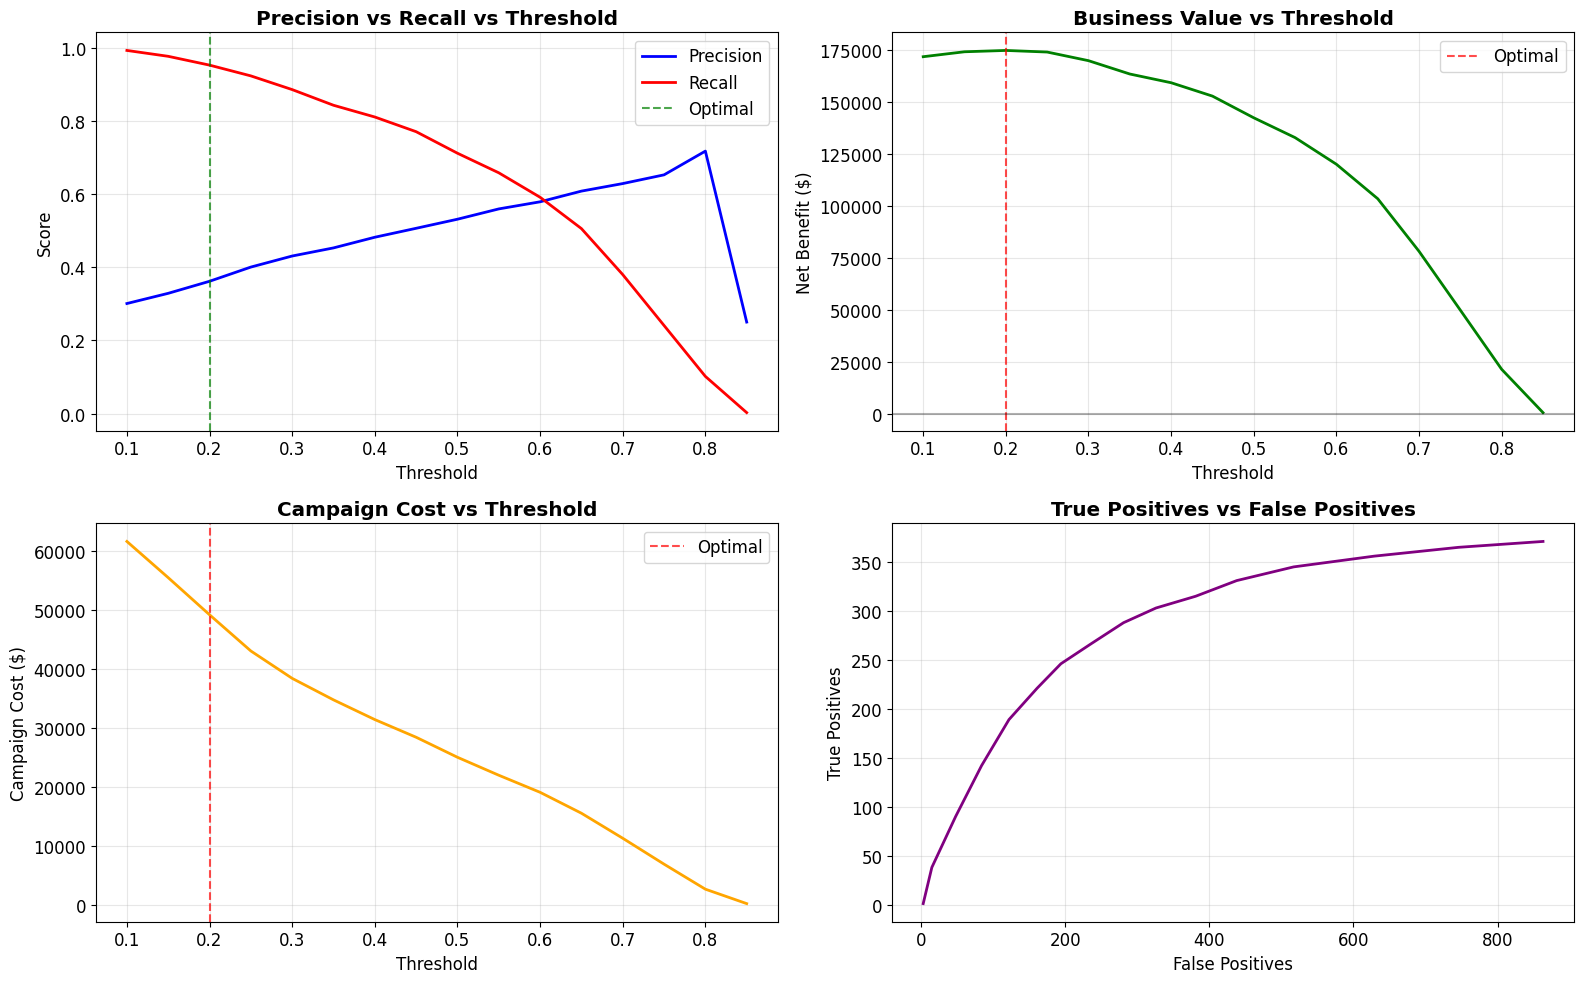


✅ Comprehensive model evaluation completed!
🎯 Model ready for deployment and business implementation!


In [20]:
# 7. THRESHOLD OPTIMIZATION
print(f"\n7️⃣ Threshold Optimization for Business Objectives...")

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    thresh_predictions = (test_probabilities > threshold).astype(int)
    thresh_cm = confusion_matrix(y_test_np, thresh_predictions)

    if thresh_cm.shape == (2, 2):  # Ensure we have both classes
        thresh_tp = thresh_cm[1, 1]
        thresh_fp = thresh_cm[0, 1]
        thresh_fn = thresh_cm[1, 0]

        thresh_precision = thresh_tp / (thresh_tp + thresh_fp) if (thresh_tp + thresh_fp) > 0 else 0
        thresh_recall = thresh_tp / (thresh_tp + thresh_fn) if (thresh_tp + thresh_fn) > 0 else 0

        # Business metrics
        thresh_campaign_cost = (thresh_tp + thresh_fp) * retention_campaign_cost
        thresh_revenue_saved = thresh_tp * retention_success_rate * customer_lifetime_value
        thresh_net_benefit = thresh_revenue_saved - thresh_campaign_cost

        threshold_results.append({
            'threshold': threshold,
            'precision': thresh_precision,
            'recall': thresh_recall,
            'net_benefit': thresh_net_benefit,
            'campaign_cost': thresh_campaign_cost,
            'true_positives': thresh_tp,
            'false_positives': thresh_fp
        })

# Convert to DataFrame for analysis
threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold (maximize net benefit)
optimal_idx = threshold_df['net_benefit'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_net_benefit = threshold_df.loc[optimal_idx, 'net_benefit']

print(f"🎯 Optimal Business Threshold: {optimal_threshold:.2f}")
print(f"💰 Maximum Net Benefit: ${optimal_net_benefit:,.0f}")

# Plot threshold analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Precision vs Recall vs Threshold
ax1.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall', linewidth=2)
ax1.axvline(x=optimal_threshold, color='green', linestyle='--', alpha=0.7, label='Optimal')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision vs Recall vs Threshold', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Net Benefit vs Threshold
ax2.plot(threshold_df['threshold'], threshold_df['net_benefit'], 'g-', linewidth=2)
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, label='Optimal')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Net Benefit ($)')
ax2.set_title('Business Value vs Threshold', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Campaign Cost vs Threshold
ax3.plot(threshold_df['threshold'], threshold_df['campaign_cost'], 'orange', linewidth=2)
ax3.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, label='Optimal')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Campaign Cost ($)')
ax3.set_title('Campaign Cost vs Threshold', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# True Positives vs False Positives
ax4.plot(threshold_df['false_positives'], threshold_df['true_positives'], 'purple', linewidth=2)
ax4.set_xlabel('False Positives')
ax4.set_ylabel('True Positives')
ax4.set_title('True Positives vs False Positives', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Comprehensive model evaluation completed!")
print(f"🎯 Model ready for deployment and business implementation!")